<a href="https://colab.research.google.com/github/yoannmorello2/pytorch_geometric/blob/master/Copie_de_3_arithmetic_tree_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 28.3 MB/s 
     |████████████████████████████████| 3.5 MB 37.6 MB/s 


# Graph Classification with Graph Neural Networks

[Previous: Node Classification with Graph Neural Networks](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX)

In this tutorial session we will have a closer look at how to apply **Graph Neural Networks (GNNs) to the task of graph classification**.
Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.
Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand.

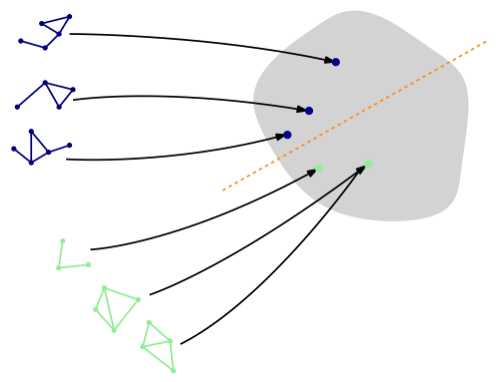

In [ ]:
import numpy as np
class Tree(object):
        def __init__(self, entry, left=None, right=None):
            self.entry = entry
            self.left = left
            self.right = right
        def __repr__(self):
            args = repr(self.entry)
            if self.left or self.right:
                args += ', {0}, {1}'.format(repr(self.left), repr(self.right))
            return 'Tree({0})'.format(args)
        def depth(self):
            if self.left == self.right == None:
                return 0
            elif (self.left !=None)&(self.right !=None):
                left_depth = self.left.depth()
                right_depth = self.right.depth()
                return max(left_depth+1,right_depth+1)
        def leaves(self):
            if self.left == self.right == None:
                return [self.entry]
            return self.left.leaves()+self.right.leaves()
        def width(self):
            return len(self.leaves())
        def formula(self):
            form = list(str(self.entry))
            if self.left or self.right:
                form = form + self.right.formula()+[')']
                form = ['('] +self.left.formula() + form
            return form
        def get_nodes(self):  #in the same order as they appear in the formula
            form = list(str(self.entry))
            if self.left or self.right:
                form = form + self.right.get_nodes()
                form = self.left.get_nodes() + form
            return form
        def adj_dim(self):
            return len(self.get_nodes())
        def absisse_of_left_one(self):
            if self.left == None:
                return 0
            else:
                if self.left.left == None: 
                    return 0
                else:
                    return self.left.left.adj_dim()
        def absisse_of_right_one(self):
            if self.right == None:
                return 0
            else:
                if self.right.left == None:
                    return 0
                else:
                    return self.right.left.adj_dim()

        def graph(self):  
            nodes = self.get_nodes()
            dim = self.adj_dim()
            if dim == 1:
                return nodes, np.zeros((1,1))
            left_dim = self.left.adj_dim()
            right_dim = self.right.adj_dim()
            diag_left = self.left.graph()[1]
            diag_right = self.right.graph()[1]
            haut = np.concatenate((diag_left,np.zeros((left_dim,dim-left_dim))),axis=1)
            bas = np.concatenate((np.zeros((right_dim,dim-right_dim)),diag_right),axis=1)
            i_left = self.absisse_of_left_one()
            i_right = self.absisse_of_right_one()
            haut[i_left,left_dim] = 1
            bas[i_right, left_dim] = 1
            adj = np. concatenate((haut, np.zeros((1,dim)), bas),axis=0)
            return nodes, adj


In [ ]:
tree=Tree('+',Tree('*',Tree(4),Tree(2)),Tree('*',Tree(3),Tree(5)))

In [ ]:
repr(tree)

"Tree('+', Tree('*', Tree(4), Tree(2)), Tree('*', Tree(3), Tree(5)))"

In [ ]:
tree.formula()

['(', '(', '4', '*', '2', ')', '+', '(', '3', '*', '5', ')', ')']

In [ ]:
tree.graph()

(['4', '*', '2', '+', '3', '*', '5'], array([[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]]))

In [ ]:
import random
def tree_generator(variables, connectors, max_depth):
    if max_depth == 0:
        return Tree(random.choice(variables))
    else:
      left_depth = random.randint(0,max_depth-1)
      right_depth = random.randint(0,max_depth-1)
      return Tree(random.choice(connectors),tree_generator(variables, connectors, left_depth),tree_generator(variables, connectors, left_depth))

In [ ]:
class ArithmeticTree(Tree):
    def __init__(self, entry, left=None, right=None):
        super().__init__(entry, left, right)
    def eval(self):
        if self.left == None:
            return int(self.entry)
        else:
            if self.entry == '+':
                return self.left.eval() + self.right.eval()
            if self.entry == '*':
                return self.left.eval() * self.right.eval()
            if self.entry == '-':
                return self.left.eval() - self.right.eval()


In [ ]:
def arithmetic_tree_generator(variables, connectors, max_depth):
    if max_depth == 0:
        return ArithmeticTree(random.choice(variables))
    else:
      left_depth = random.randint(0,max_depth-1)
      right_depth = random.randint(0,max_depth-1)
      return ArithmeticTree(random.choice(connectors),arithmetic_tree_generator(variables, connectors, left_depth),arithmetic_tree_generator(variables, connectors, left_depth))

In [ ]:
from torch_geometric.data import Data
import networkx as nx
def arith_data_gen(variables,connectors, max_depth, n_samples):
    data_set = []
    for i in range(n_samples):
        tree = arithmetic_tree_generator(variables, connectors, max_depth)
        graph = tree.graph()
        nodes = graph[0]
        adj_mat = graph[1]
        y = torch.tensor(tree.eval()/10000)
        net_graph = nx.from_numpy_matrix(adj_mat,  create_using=nx.DiGraph)
        dic_nodes = dict(zip(list(range(tree.adj_dim())), nodes))
        nx.set_node_attributes(net_graph,dic_nodes,'x')
        #net_graph.graph['y'] = y
        data_set.append((net_graph,y))
    return data_set

the task with arithmetic expression of max_depth 4 and operators '+' and '*'

In [ ]:
variables = list(np.arange(10))
connectors = ['+','*']
net_data = arith_data_gen(variables, connectors, max_depth=4, n_samples =10000)

In [ ]:
net_data[500]

(<networkx.classes.digraph.DiGraph at 0x7faf9442af90>, tensor(72))

Finally we transform our database in a pytorch geometric database


In [ ]:
range(*slice(5,8).indices(10))

range(5, 8)

In [ ]:
from torch.utils.data import Dataset
from torch_geometric.utils.convert import to_networkx, from_networkx
class CustomDataset(Dataset):
    def __init__(self, net_data, transform=None, target_transform=None):
        self.net_data = net_data
        self.transform = transform
    def __len__(self):
        return len(self.net_data)

    def __getitem__(self, idx):
        if isinstance(idx, int):
            if idx < 0 : #Handle negative indices
              idx += len( self )
            else:
              pygra = from_networkx(self.net_data[idx][0])
              pygra.y = torch.tensor(np.array(self.net_data[idx][1],ndmin=1))
              if self.transform:
                  pygra.x = self.transform(pygra.x) 
              
            return pygra
        elif isinstance(idx, slice ) :
            #Get the start, stop, and step from the slice
            return [self[ii] for ii in range(*idx.indices(len(self)))]
    

In [ ]:
class One_Hot_nodes(object):
    def __init__(self, variables,connectors):
        self.l = len(variables+connectors)
        self.map = dict(zip(variables+connectors,range(self.l)))
        
    def __call__(self,liste):
        self.enc = np.zeros((len(liste),self.l))
        for i, node in enumerate(liste):
            try :
                self.enc[i, self.map[int(node)]] = 1
            except :
                self.enc[i, self.map[node]] = 1
        return torch.from_numpy(self.enc)

In [ ]:
pyg_graphs = CustomDataset(net_data,transform = One_Hot_nodes(variables,connectors))

In [ ]:
pyg_graphs[0].x

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [ ]:
from_networkx(net_data[0])

Data(x=[7], edge_index=[2, 6], y=24, weight=[6])

In [ ]:
 


# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout






def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    
    pos = graphviz_layout(G, prog="dot")
    nx.draw_networkx(G, pos=pos, with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [ ]:
visualize_graph(net_graph,'white')

NameError: ignored

In [ ]:
dataset = pyg_graphs
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
#print(f'Number of features: {dataset.num_features}')
#print(f'Number of classes: {dataset.num_classes}')

data = dataset[0] # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: <__main__.CustomDataset object at 0x7faf923c6fd0>:
Number of graphs: 10000

Data(x=[11, 12], edge_index=[2, 10], weight=[10], y=[1])
Number of nodes: 11
Number of edges: 10
Average node degree: 0.91
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [ ]:
import torch.nn.functional as F

In [ ]:
pyg_graphs[800]

Data(x=[7, 12], edge_index=[2, 6], weight=[6], y=[1])

In [ ]:

dataset = pyg_graphs
train_dataset = dataset[:800]
test_dataset = dataset[800:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 800
Number of test graphs: 9200


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data.y)
    print()

Step 1:
Number of graphs in the current batch: 64
[array([0]), array([1080]), array([0]), array([53]), array([1]), array([16]), array([200]), array([1002]), array([63]), array([26]), array([11]), array([23]), array([6]), array([6]), array([16]), array([13]), array([112]), array([9]), array([136080]), array([273]), array([0]), array([6426]), array([1960]), array([1075]), array([6]), array([0]), array([129]), array([60480]), array([486]), array([126]), array([1170]), array([64]), array([78]), array([5]), array([0]), array([62]), array([96]), array([0]), array([104]), array([30]), array([14]), array([630]), array([35251200]), array([3744]), array([78]), array([84]), array([10]), array([4]), array([2802]), array([3]), array([0]), array([579]), array([336]), array([40]), array([1944]), array([21]), array([0]), array([10]), array([34992]), array([31]), array([27]), array([160]), array([559]), array([70])]

Step 2:
Number of graphs in the current batch: 64
[array([14]), array([14]), array([0]

In [ ]:
for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x.float(), data.edge_index, data.batch)
         print(out.dtype)
         print(data.y.dtype)

torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64


In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(12, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = torch.squeeze(self.lin(x))
        
        return x

model = GCN(hidden_channels=64)
#model = model.float()
print(model)

GCN(
  (conv1): GCNConv(12, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
model.parameters()

<generator object Module.parameters at 0x7faf93b0e250>

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x.float(), data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y.float())  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         print(f'Loss: {loss:.4f}')
         

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x.float(), data.edge_index, data.batch)  
         pred = out  
         correct += int(torch.mul((data.y-1 < pred),(pred < data.y+1)).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d},  Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Loss: 3.8756
Loss: 7631.4209
Loss: 0.0601
Loss: 0.0684
Loss: 0.5933
Loss: 0.2983
Loss: 0.3222
Loss: 4023.9817
Loss: 2.0799
Loss: 0.6871
Loss: 5103.3052
Loss: 1.8628
Loss: 0.0041
Epoch: 001,  Train Acc: 0.9650, Test Acc: 0.9662
Loss: 3.9392
Loss: 32.2394
Loss: 7630.2109
Loss: 2.0938
Loss: 0.0932
Loss: 0.6416
Loss: 3990.8210
Loss: 0.0097
Loss: 5102.6172
Loss: 0.0106
Loss: 1.8127
Loss: 0.9283
Loss: 0.0160
Epoch: 002,  Train Acc: 0.9663, Test Acc: 0.9668
Loss: 0.5269
Loss: 1.4039
Loss: 3.7199
Loss: 0.8950
Loss: 0.0199
Loss: 0.5670
Loss: 3990.0378
Loss: 12762.3467
Loss: 0.0478
Loss: 0.0293
Loss: 0.7640
Loss: 2.0713
Loss: 1.1841
Epoch: 003,  Train Acc: 0.9663, Test Acc: 0.9680
Loss: 0.2150
Loss: 0.5269
Loss: 5102.3608
Loss: 7625.3989
Loss: 0.3013
Loss: 0.0869
Loss: 0.0890
Loss: 1.1527
Loss: 32.5448
Loss: 3985.5835
Loss: 0.9124
Loss: 1.3848
Loss: 0.4531
Epoch: 004,  Train Acc: 0.9688, Test Acc: 0.9700
Loss: 5100.2407
Loss: 0.4020
Loss: 32.0337
Loss: 0.1906
Loss: 0.4225
Loss: 0.7398
Loss: 3.72